In [1]:
#imports
from pysdot.domain_types import ConvexPolyhedraAssembly
#from pysdot.domain_types import ScaledImage
from pysdot import OptimalTransport
from pysdot import PowerDiagram
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import time as tm

import PyAPD
import torch

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [47]:
L = 1
N = 100
ln_mean=1; # mean of the distribution
std_dev=0.35; # standard deviation of the distribution
sigma=np.sqrt((np.log(1+(std_dev/ln_mean)**2))); # log-normal parameter sigma
mu=-0.5*sigma**2+np.log(ln_mean); # log-normal parameter mu

# Draw the radii from the log-normal distribution
radii=np.random.lognormal(mu,sigma,N);
target_vols=radii**2

# Log-normal target_vols
target_vols=L**2*target_vols/np.sum(target_vols)

# monodisperse:
target_vols=L**3*np.ones(N)/N


apd = PyAPD.apd_system(N=N,ani_thres=0,pixel_size_prefactor=2, dt=torch.float64, target_masses = torch.tensor(target_vols),seed = 10)

apd.target_masses

weights0 = apd.W
weights0

grads_pyapd, error_pyapd = apd.check_optimality(return_gradient_and_error=True)

np.array(grads_pyapd)

dd = apd.domain.numpy().transpose()
dm=ConvexPolyhedraAssembly(); # Create a polyhedral assembly
dm.add_box(dd[0],dd[1])
ot=OptimalTransport(positions=apd.X.numpy(),weights=weights0.numpy(),masses=apd.target_masses.numpy(),domain=dm,verbosity=2)
ot.set_stopping_criterion(apd.target_masses[0]*apd.error_tolerance, type="max delta masses")

target = apd.target_masses[0]*apd.error_tolerance
target

mvs = ot.pd.der_integrals_wrt_weights(stop_if_void=True)

grads_pysdot = mvs.v_values - ot.masses
grads_pysdot

error_pysdot0 = np.max(np.abs((grads_pysdot/ot.masses[0])))
error_pysdot0

error_pyapd0 = np.max(np.abs(np.array((grads_pyapd/apd.target_masses[0]))))
error_pyapd0

diff0 = np.max(np.abs(np.array(grads_pyapd) - grads_pysdot))
diff0

st=tm.time()
ot.adjust_weights()
en=tm.time()
print('Elapsed time {}'.format(en-st))

mvs2 = ot.pd.der_integrals_wrt_weights(stop_if_void=True)

grads_pysdot2 = mvs2.v_values - ot.masses
grads_pysdot2

error_pysdot2 = np.max(np.abs((grads_pysdot2/ot.masses[0])))
error_pysdot2

apd.set_W(torch.tensor(ot.get_weights()))

grads_pyapd2, error_pyapd2 = apd.check_optimality(return_gradient_and_error=True)

error_pyapd2 = np.max(np.abs(np.array((grads_pyapd2/apd.target_masses[0]))))
error_pyapd2

diff2 = np.max(np.abs(np.array(grads_pyapd2) - grads_pysdot2))
diff2

print("PyAPD error0: ", error_pyapd0, ", pysdot error0: ", error_pysdot0)
print("Difference in grads 0: ",diff0)

print("PyAPD error2: ", error_pyapd2, ", pysdot error2: ", error_pysdot2)
print("Difference in grads 2: ", diff2)

Precision loss detected!
Percentage error =  182.5000000000055
Sucessfully imported sparse linear solver Scipy.
max dm: 0.01832800553720057
max dm: 0.01642455071154754
max dm: 0.0021443863723939107
max dm: 9.363230557302496e-05
Elapsed time 0.007977485656738281
Precision loss detected!
Percentage error =  2.2500000000003593
PyAPD error0:  1.825000000000055 , pysdot error0:  1.832800553720057
Difference in grads 0:  0.00019737031091750235
PyAPD error2:  0.022500000000003594 , pysdot error2:  0.009363230557302496
Difference in grads 2:  0.00022500103294764706


In [46]:
apd.X[1]

tensor([0.7116, 0.5504])

In [48]:
apd.find_optimal_W()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0001)
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.017251
         Iterations: 3
         Function evaluations: 5
It took 0.14004778861999512 seconds to find optimal W.


In [49]:
apd.set_W(weights0)
apd.check_optimality()

Precision loss detected!
Percentage error =  182.5000000000055


In [50]:
apd.find_optimal_W()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0001)
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.017251
         Iterations: 60
         Function evaluations: 63
It took 0.9105648994445801 seconds to find optimal W.


In [6]:
colors = [np.random.randint(N) for x in range(apd.N)]

(<Figure size 756x756 with 1 Axes>, <Axes: >)

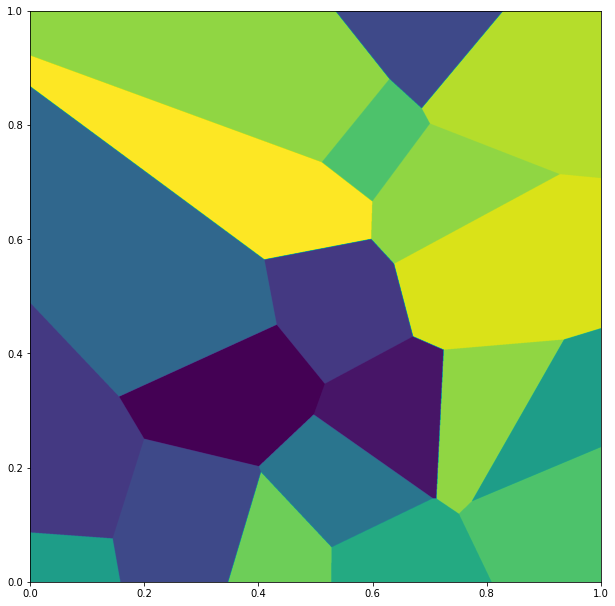

In [7]:
apd.plot_apd(color_by = torch.tensor(colors))

In [8]:
dd = apd.domain.numpy().transpose()
dd

array([[0., 0.],
       [1., 1.]])

In [9]:
weights0 = apd.W
weights0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
apd.find_optimal_W()
apd.check_optimality()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0005)
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.040233
         Iterations: 18
         Function evaluations: 20
It took 11.711706638336182 seconds to find optimal W.
The APD is optimal!
Percentage error =  0.9946280989871215


(<Figure size 756x756 with 1 Axes>, <Axes: >)

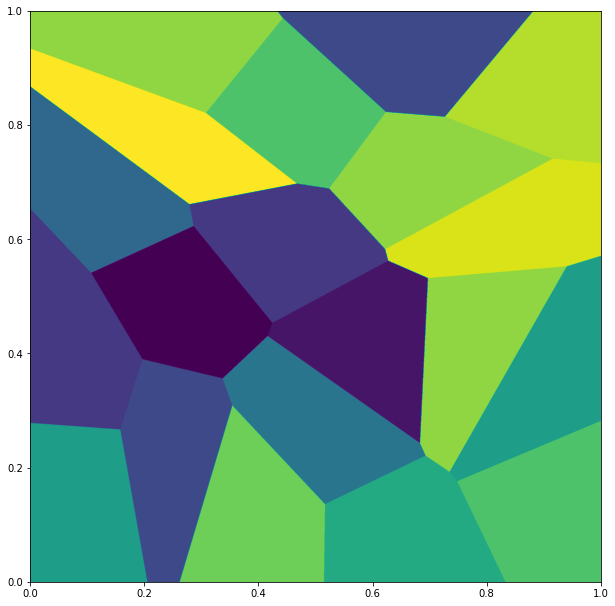

In [11]:
apd.plot_apd(color_by = torch.tensor(colors))

In [12]:
dm=ConvexPolyhedraAssembly(); # Create a polyhedral assembly
dm.add_box(dd[0],dd[1])
#dm.add_box([0,0,0],[L,L,L]);

In [13]:
apd.error_tolerance

0.01

In [14]:
ot=OptimalTransport(positions=apd.X.numpy(),weights=weights0.numpy(),masses=apd.target_masses.numpy(),domain=dm,verbosity=2)
ot.set_stopping_criterion(apd.target_masses[0]*apd.error_tolerance, type="max delta masses")

In [16]:
# Store the volumes in an array
vols=ot.pd.integrals();
# Save the results in a .vtk file
filename="results.vtk";
ot.pd.display_vtk(filename)

# Read the data
grid=pv.read(filename)
# create cell data that gives the cell volumes, this allows us to colour by cell volumes
cell_vols=vols[grid.cell_data['num'].astype(int)]
grid.cell_data['vols']= colors 

# plot the data with an automatically created plotter, for a static picture use backend='static'
#grid.plot(scalars='vols',jupyter_backend='static',background='white')
plotter = pv.Plotter(window_size=[800,800],notebook=True)
plotter.add_mesh(grid)
plotter.show()

Widget(value="<iframe src='http://localhost:44189/index.html?ui=P_0x7fb9885fdf10_1&reconnect=auto' style='widt…

In [17]:
st=tm.time()
ot.adjust_weights()
en=tm.time()
print('Elapsed time {}'.format(en-st))

Sucessfully imported sparse linear solver Scipy.
max dm: 0.0845334860807249
max dm: 0.023064141142965996
max dm: 0.0010927711857267389
max dm: 2.962336640446872e-06
Elapsed time 0.012407302856445312


In [19]:
apd.W

tensor([-0.0784, -0.0306,  0.0342, -0.0643, -0.0350, -0.0785,  0.0206,  0.0739,
         0.0474, -0.0365,  0.0609, -0.0379, -0.0412,  0.0443,  0.0549, -0.0483,
         0.0519,  0.0687, -0.0814,  0.0752])

In [18]:
ot.get_weights()

array([ 5.31831239e-17,  4.79855774e-02,  1.12952504e-01,  1.40792081e-02,
        4.34611663e-02,  2.77761459e-04,  9.95667805e-02,  1.52195305e-01,
        1.25933974e-01,  4.22528078e-02,  1.39234373e-01,  4.06156503e-02,
        3.74311690e-02,  1.22861078e-01,  1.33386853e-01,  3.04148612e-02,
        1.30475000e-01,  1.47062315e-01, -3.10973378e-03,  1.54533609e-01])

In [22]:
apd.set_W(torch.tensor(ot.get_weights()))

In [23]:
wtf0 = apd.check_optimality(error_wrt_each_grain = False, return_gradient_and_error=True)

The APD is optimal!
Percentage error =  0.11570247952792656


In [24]:
lol = ot.pd.der_integrals_wrt_weights()

wtf1 = (lol.v_values - ot.masses)/ot.masses[0]

In [25]:
torch.abs(wtf0[0]/wtf1)

tensor([3.6719e+00, 4.9009e-02, 2.9158e-02, 1.9020e+00, 7.0682e+01, 3.8862e-02,
        6.3357e+00, 1.2837e+00, 9.3524e-01, 1.5200e-02, 1.4029e+01, 4.5026e-07,
        1.5853e+01, 8.9100e-02, 5.1043e-02, 1.3391e-01, 1.2304e-01, 3.7649e-02,
        4.8943e-02, 5.9863e-01])

In [330]:
apd.target_masses

tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500])

In [380]:
wtf0

(tensor([-1.6529e-06,  2.9959e-05, -5.1653e-06, -3.6364e-05,  8.6777e-06,
         -8.6777e-06, -8.2645e-07, -1.2397e-06, -1.5289e-05,  6.1983e-07,
          3.0227e-04, -1.6529e-06,  1.8595e-06, -4.4008e-05,  2.1405e-04,
         -4.4835e-05,  5.9298e-05,  8.2645e-07, -3.9256e-06, -4.5393e-04]),
 tensor(0.0091))

In [381]:
wtf1

array([-2.18075289e-05,  6.14968733e-04, -1.01254875e-04, -7.31608846e-04,
        1.51896076e-04, -1.56573823e-04, -1.36664292e-05, -2.18350168e-05,
       -3.08038448e-04, -8.11448740e-07,  6.03887898e-03, -3.84490827e-05,
        2.77232276e-05, -8.85411138e-04,  4.27878931e-03, -8.95816951e-04,
        1.17957621e-03,  2.90548548e-05, -6.77142867e-05, -9.07789952e-03])